In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)    

from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
import config

from HySpecLab.utils import HyperSpectralCalibration as calibration
from HySpecLab.utils import median

# VNIR

In [2]:
X = np.load(os.path.join(config.POLYMER_DATASET_DIR, 'Sensor_VNIR/C1_VNIR/processed/C1_VNIR.npy'))
tiny_X = X.reshape((X.shape[0]*X.shape[1],X.shape[2]))

## Band reduction
### Equidistant selection

In [3]:
n_bands = 128
bands = np.linspace(0, X.shape[2]-1, num=n_bands, dtype=np.uint)

X = X[:,:,bands].copy()
tiny_X = X.reshape((X.shape[0]*X.shape[1],X.shape[2]))

## Normalization

In [4]:
from HySpecLab.transform import Norm1Transform, StandarizedTransform

tiny_X_norm = Norm1Transform().fit_transform(tiny_X)
tiny_X_std = StandarizedTransform().fit_transform(tiny_X)

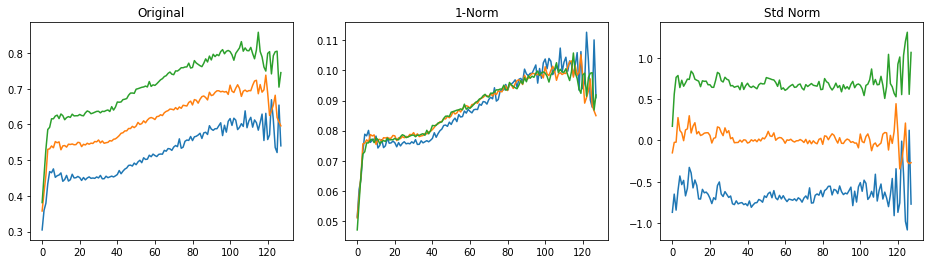

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

samples_idx = np.arange(0, 1200, 400)

ax[0].set_title('Original')
ax[0].plot(tiny_X[samples_idx].T)
ax[1].set_title('1-Norm')
ax[1].plot(tiny_X_norm[samples_idx].T)
ax[2].set_title('Std Norm')
ax[2].plot(tiny_X_std[samples_idx].T)


plt.show()

# PCA Classification

In [6]:
w, h, b = X.shape

In [7]:
from sklearn.decomposition import PCA

n_components = 4

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(tiny_X.copy())
X_pca = X_pca.reshape(w, h, n_components)

X_pca_norm = pca.fit_transform(tiny_X_norm.copy())
X_pca_norm = X_pca_norm.reshape(w, h, n_components)

X_pca_std = pca.fit_transform(tiny_X_std.copy())
X_pca_std = X_pca_std.reshape(w, h, n_components)

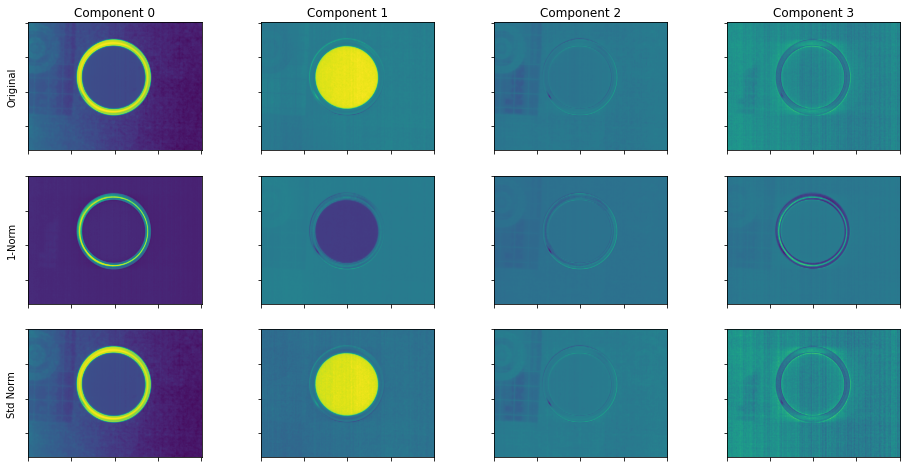

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=n_components, figsize=(16,8))

for i in range(n_components):
    ax[0, i].imshow(X_pca[:,:,i])
    ax[0, i].set_title('Component {}'.format(i))
    ax[0, i].set_xticklabels([])
    ax[0, i].set_yticklabels([])

ax[0, 0].set_ylabel('Original')

for i in range(n_components):
    ax[1, i].imshow(X_pca_norm[:,:,i])
    ax[1, i].set_xticklabels([])
    ax[1, i].set_yticklabels([])

ax[1, 0].set_ylabel('1-Norm')

for i in range(n_components):
    ax[2, i].imshow(X_pca_std[:,:,i])
    ax[2, i].set_xticklabels([])
    ax[2, i].set_yticklabels([])

ax[2, 0].set_ylabel('Std Norm')

plt.show()


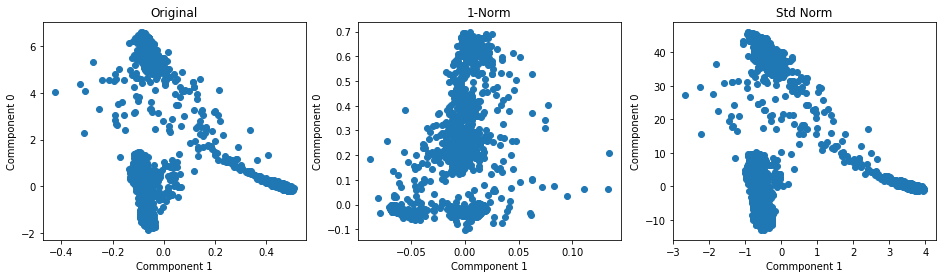

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

ax[0].set_title('Original')
ax[0].set_xlabel('Commponent 1')
ax[0].set_ylabel('Commponent 0')
ax[0].scatter(X_pca[:,:, 1].flatten()[::50], X_pca[:,:, 0].flatten()[::50])

ax[1].set_title('1-Norm')
ax[1].set_xlabel('Commponent 1')
ax[1].set_ylabel('Commponent 0')
ax[1].scatter(X_pca_norm[:,:, 1].flatten()[::50], X_pca_norm[:,:, 0].flatten()[::50])

ax[2].set_title('Std Norm')
ax[2].set_xlabel('Commponent 1')
ax[2].set_ylabel('Commponent 0')
ax[2].scatter(X_pca_std[:,:, 1].flatten()[::50], X_pca_std[:,:, 0].flatten()[::50])
plt.show()

# Visualization

In [10]:
# data = X_pca
data = X_pca_norm
# data = X_pca_std

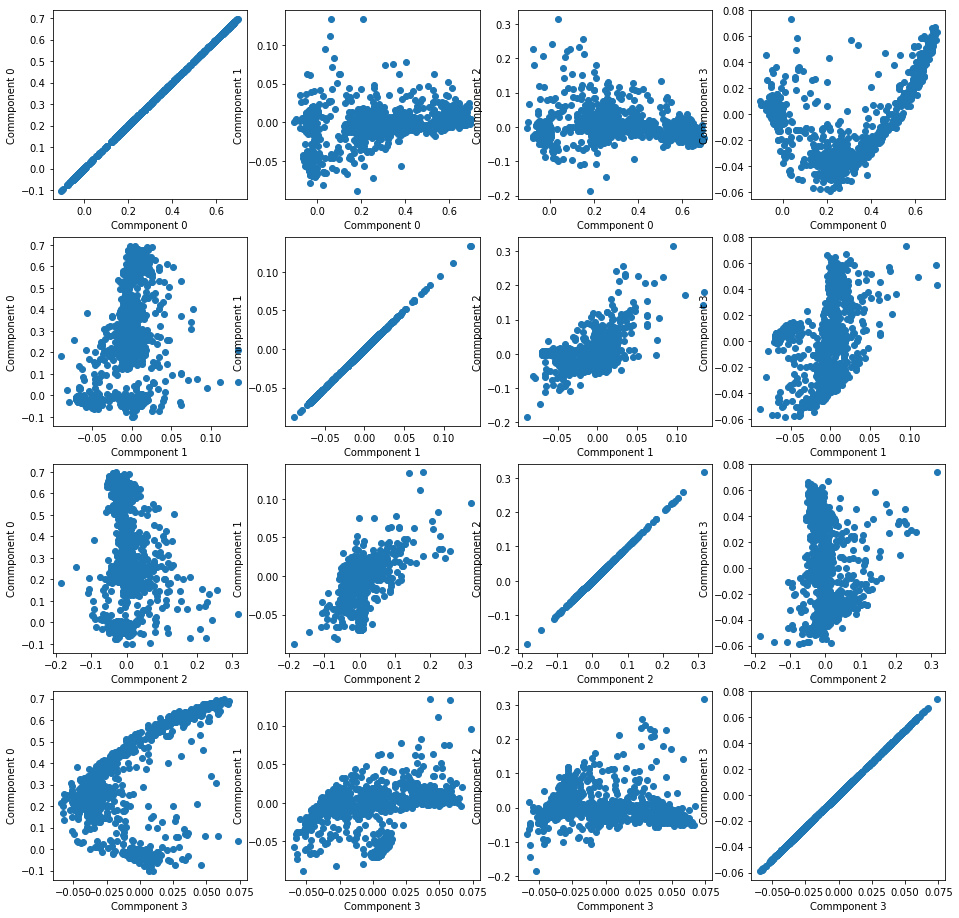

In [11]:
fig, ax = plt.subplots(nrows=n_components, ncols=n_components, figsize=(16, 16))

for i in range(n_components):
    for j in range(n_components):
        ax[i,j].scatter(data[:,:, i].flatten()[::50], data[:,:, j].flatten()[::50])
        ax[i,j].set_xlabel('Commponent {}'.format(i))
        ax[i,j].set_ylabel('Commponent {}'.format(j))

plt.show()

In [12]:
cmp_0 = data[:,:, 0].flatten().reshape(-1,1)
cmp_1 = data[:,:, 1].flatten().reshape(-1,1)

X = np.concatenate([cmp_0, cmp_1], axis=1)

In [13]:
from sklearn.cluster import KMeans
n_clusters = 3
model = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

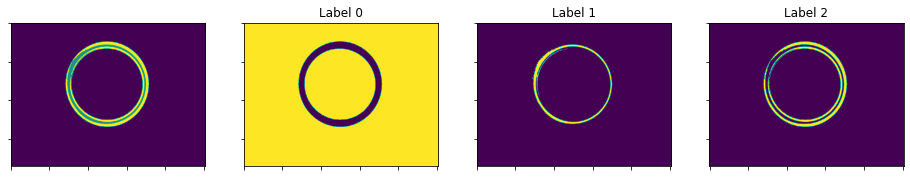

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=n_clusters+1, figsize=(16,4))

result = model.labels_.reshape(w, h)

ax[0].imshow(result)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

for i in range(n_clusters):
    mask = np.zeros(result.shape)
    mask[np.where(result==i)] = 1
    ax[i+1].imshow(mask)
    ax[i+1].set_title('Label {}'.format(i))
    ax[i+1].set_xticklabels([])
    ax[i+1].set_yticklabels([])

plt.show()

# Custom PCA

Just for testing!

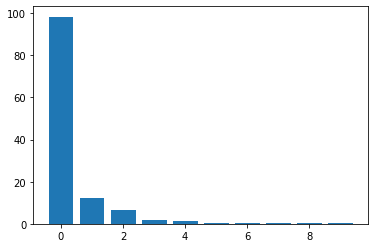

In [51]:
from numpy import linalg
selected_data = tiny_X_norm

selected_data_std = (tiny_X_norm - tiny_X_norm.mean(axis=0)) / tiny_X_norm.std(axis=0) 

C = np.cov(selected_data_std.T)
D,V = linalg.eig(C)
D = D.real

plt.bar(np.arange(len(D[:10])), D[:10])
plt.show()

In [54]:
TinyVecsPCA = np.dot(V.T, selected_data.T)
PCACovar    = np.cov(TinyVecsPCA)

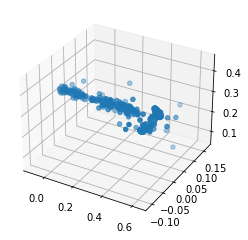

In [63]:
# %matplotlib widget
fig = plt.figure(13)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(TinyVecsPCA[0,np.arange(0, len(selected_data), 200)],TinyVecsPCA[1,np.arange(0, len(selected_data), 200)],TinyVecsPCA[2,np.arange(0, len(selected_data), 200)], marker='o')
plt.show()

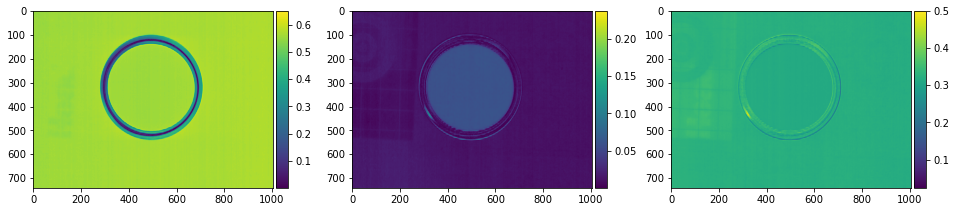

In [90]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

n_components = 3
fig, ax = plt.subplots(nrows=1, ncols=n_components, figsize=(16,4))
plt.subplots_adjust(wspace=0.25, hspace=0)
for comp_idx in range(n_components):
    component = TinyVecsPCA[comp_idx, :]
    PCAIm = np.reshape(component, (w, h))
    img = ax[comp_idx].imshow   (np.abs(PCAIm))

    divider = make_axes_locatable(ax[comp_idx])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')
    
plt.show()